# Glow

In [1]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

/home/ubuntu/.cache/pypoetry/virtualenvs/nflows-VYLojdXp-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up model

# Define flows
L = 3
K = 16
torch.manual_seed(0)

input_shape = (3, 32, 32)
n_dims = np.prod(input_shape)
channels = 3
hidden_channels = 256
split_mode = 'channel'
scale = True
num_classes = 10

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                    input_shape[2] // 2 ** (L - i))
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]


# Construct flow model
model = nf.MultiscaleFlow(q0, flows, merges)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

/home/ubuntu/.cache/pypoetry/virtualenvs/nflows-VYLojdXp-py3.8/lib/python3.8/site-packages/normflows/flows/mixing.py:72: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  Q = torch.qr(torch.randn(self.num_channels, self.num_channels))[0]
/home/ubuntu/.cache/pypoetry/virtualenvs/nflows-VYLojdXp-py3.8/lib/python3.8/site-packages/torch/_tensor.py:662: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivot

In [8]:
# Prepare training data
batch_size = 128
data_path = "/mnt/vol_b/datasets/"
transform = tv.transforms.Compose([tv.transforms.ToTensor(), nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.)])
train_data = tv.datasets.CIFAR10(data_path, train=True,
                                 download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

test_data = tv.datasets.CIFAR10(data_path, train=False,
                                download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

train_iter = iter(train_loader)
x, y = next(train_iter)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
y

tensor([8, 5, 4, 5, 0, 6, 3, 2, 5, 2, 8, 5, 2, 5, 7, 1, 5, 1, 5, 3, 9, 2, 0, 9,
        9, 1, 2, 7, 5, 6, 1, 5, 0, 3, 1, 8, 6, 2, 6, 7, 9, 2, 5, 8, 2, 7, 3, 9,
        6, 7, 1, 4, 8, 9, 2, 1, 6, 7, 5, 5, 6, 8, 3, 4, 8, 4, 9, 5, 1, 6, 3, 2,
        0, 8, 8, 1, 0, 9, 5, 0, 6, 8, 8, 9, 0, 0, 7, 7, 6, 5, 7, 0, 5, 0, 9, 5,
        6, 2, 5, 8, 8, 4, 7, 3, 3, 7, 2, 1, 4, 8, 2, 9, 4, 5, 0, 5, 7, 6, 2, 2,
        2, 9, 1, 5, 7, 8, 1, 5])

100%|██████████| 2000/2000 [09:57<00:00,  3.35it/s]


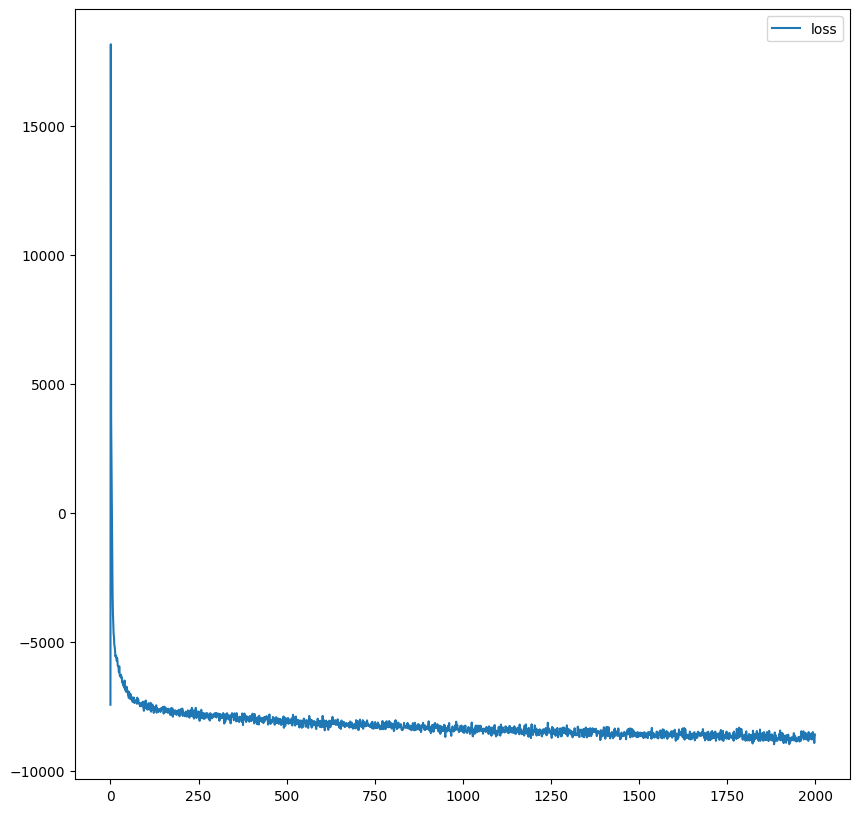

In [12]:
# Train model
max_iter = 8000

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

for i in tqdm(range(max_iter)):
    try:
        x, y = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x, y = next(train_iter)
    optimizer.zero_grad()
    loss = model.forward_kld(x.to(device), y.to(device))
        
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())
    del(x, y, loss)

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

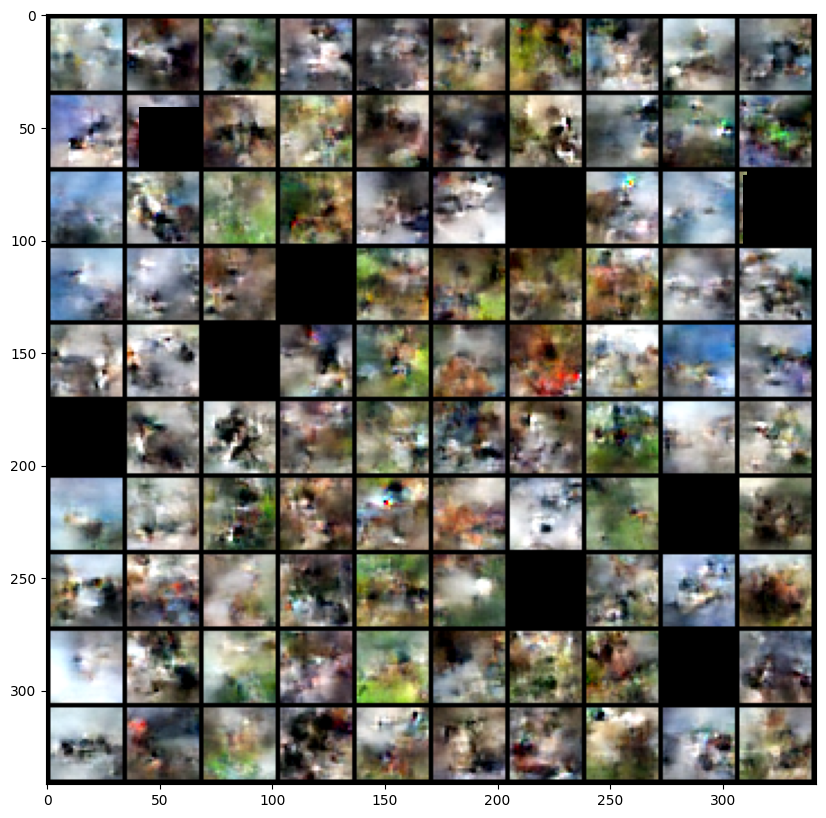

In [13]:
# Model samples
num_sample = 10

with torch.no_grad():
    y = torch.arange(num_classes).repeat(num_sample).to(device)
    x, _ = model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=num_classes).cpu().numpy(), (1, 2, 0)))
    plt.show()

    del(x, y, x_)

In [14]:
# Get bits per dim
n = 0
bpd_cum = 0
with torch.no_grad():
    for x, y in iter(test_loader):
        nll = model(x.to(device), y.to(device))
        nll_np = nll.cpu().numpy() 
        bpd_cum += np.nansum(nll_np / np.log(2) / n_dims + 8)
        n += len(x) - np.sum(np.isnan(nll_np))
        
    print('Bits per dim: ', bpd_cum / n)

Bits per dim:  3.908021900177002
